In [1]:
import networkx as nx
import matplotlib.pyplot as plt
import random
import numpy as np
import numpy.linalg as LA
import matplotlib as mpl
import matplotlib.cm as cm
import math
import requests
import json
from networkx.readwrite import json_graph
from sklearn.cluster import KMeans


Network clustering or paritioning is the process of splitting the nodes of a network into subgroups that share similar connectivity behavior. There are many natural formulations of community structure, but there is usually some kind of comparison between the relative density of the edges between nodes within the community vs. edges between different communities. The spectral clustering version below, copied from the previous notebook, starts by trying to find groups of nodes that are sparsely connected to the rest of the network. Disconnecting these groups from the network doesn't require us to "cut" too many edges. We might start by trying to optimize for this value but it quickly becomes apparent that finding the "best" cut is a difficult problem. More mathematical details can be found here: https://github.com/drdeford/Math_581_05/blob/master/Week_8/581_Clustering.pdf

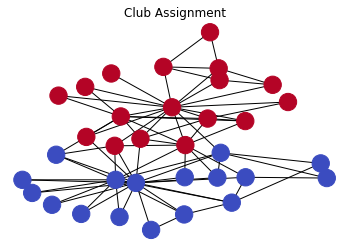

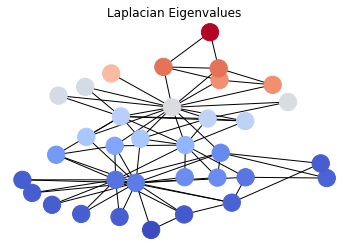

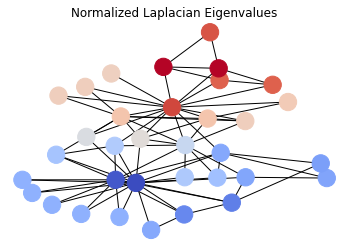

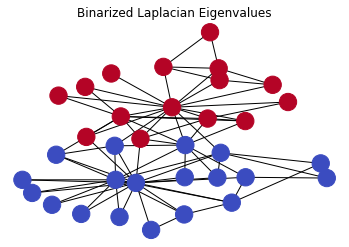

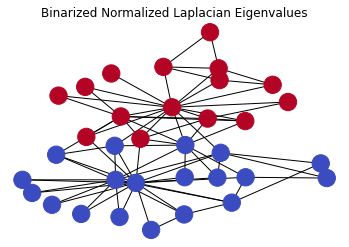

In [2]:
#We partition the nodes in the graph using the Fiedler vector of the (normalized) Laplacian 
#(the eigenvector that corresponds to the smallest non-zero eigenvalue.)
G = nx.karate_club_graph()
karate_kk_layout = nx.kamada_kawai_layout(G)


AM = nx.adjacency_matrix(G)
NLM = (nx.normalized_laplacian_matrix(G)).todense()
LM = (nx.laplacian_matrix(G)).todense()



plt.figure()
plt.title("Club Assignment")
nx.draw(G,pos=karate_kk_layout, node_color=[G.nodes[x]['club'] == 'Mr. Hi' for x in G.nodes()], cmap='coolwarm' )
plt.show()

NLMva, NLMve = LA.eigh(NLM)

LMva, LMve = LA.eigh(LM)

Fv = LMve[:,1]
xFv = [-Fv.item(x) for x in range(34)]
NFv = NLMve[:,1]
xNFv = [NFv.item(x) for x in range(34)]

plt.figure()
plt.title("Laplacian Eigenvalues")
nx.draw(G,pos=karate_kk_layout, node_color=xFv, cmap='coolwarm' )
plt.show()

plt.figure()
plt.title("Normalized Laplacian Eigenvalues")
nx.draw(G,pos=karate_kk_layout,node_color= xNFv, cmap='coolwarm')
plt.show()

plt.figure()
plt.title("Binarized Laplacian Eigenvalues")
nx.draw(G, pos=karate_kk_layout,node_color=[xFv[x] > 0 for x in range(34)], cmap='coolwarm' )
plt.show()

plt.figure()
plt.title("Binarized Normalized Laplacian Eigenvalues")
nx.draw(G,pos=karate_kk_layout,node_color= [xNFv[x] > 0 for x in range(34)], cmap='coolwarm')
plt.show()



**Assignment:** Replace the Karate club with one of the combinatorial graphs and redo the spectral partitioning. Does the output seem to reflect the structure you observe in the network?

# K-Clusters
If we want to find more than two clusters we need to do something a little more complex than just splitting the nodes by the sign of the entry in a single eigenvector. Instead, if we expect to find k-clusters then we will take k-1 eigenvectors and use k-means clustering on the rows to estimate the assignments. Usually we can use the eigenvalues of the Laplacian to suggest the number of clusters that can be recovered successfully using this method. The examples below demonstrate this with the stochastic block model, which is another random graph model designed to create networks with community structure. 

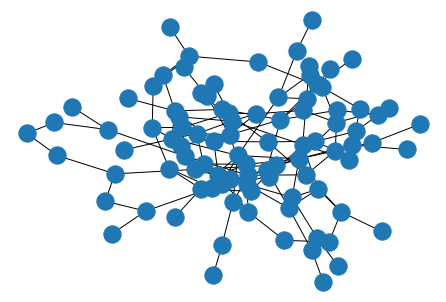

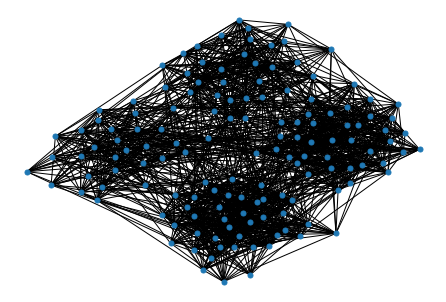

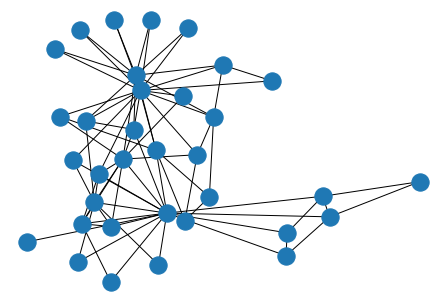

In [3]:
sizes = [30,32,41,39]
#sizes = [random.randint(30,40) for x in range(random.randint(3,10))]

probs = [[.5 if x == y else .05 for x in range(len(sizes))] for y in range(len(sizes))]
ER = nx.gnp_random_graph(100, .025)
ER = ER.subgraph(max(nx.connected_components(ER)))
SBM = nx.stochastic_block_model(sizes, probs)
K = nx.karate_club_graph()


nx.draw(ER)
plt.show()

nx.draw(SBM,node_size=25,width=1)
plt.show()

nx.draw(K)
plt.show()



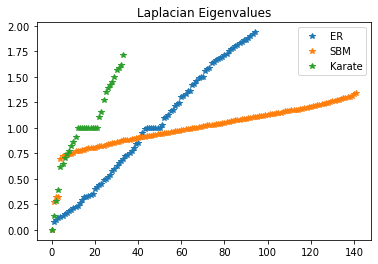

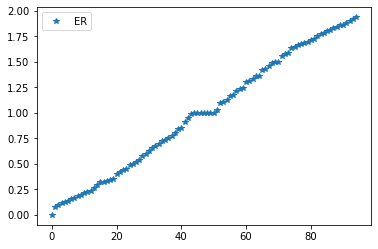

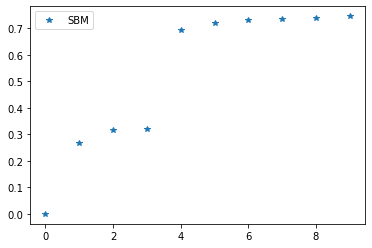

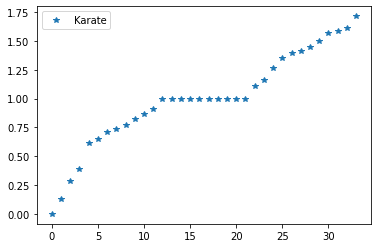

In [4]:
LMERva, LMERve = LA.eigh(nx.normalized_laplacian_matrix(ER).todense())
LMSBMva, LMSBMve = LA.eigh(nx.normalized_laplacian_matrix(SBM).todense())
LMKva, LMKve = LA.eigh(nx.normalized_laplacian_matrix(K).todense())


plt.plot(LMERva,'*',label='ER')
plt.plot(LMSBMva,'*',label='SBM')
plt.plot(LMKva,'*',label='Karate')
plt.title('Laplacian Eigenvalues')
plt.legend()
plt.show()

plt.plot(LMERva,'*',label='ER')
plt.legend()
plt.show()

plt.plot(LMSBMva[0:10],'*',label='SBM')
plt.legend()
plt.show()

plt.plot(LMKva,'*',label='Karate')
plt.legend()
plt.show()


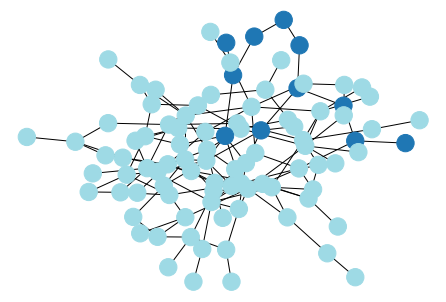

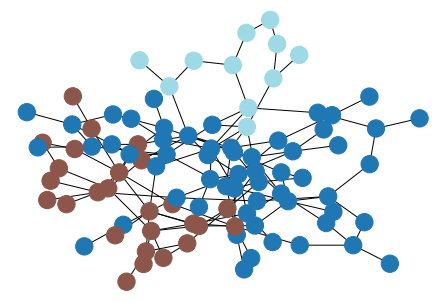

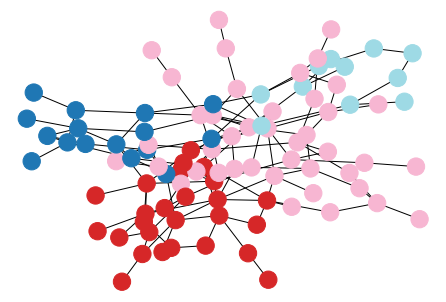

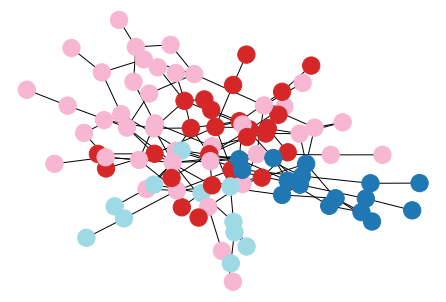

In [5]:
k=4

for i in range(2,k+1):
    X = LMERve[:,0:k]


    kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
    plt.figure()
    nx.draw(ER, node_color = kmeans.labels_, cmap = 'tab20')
    plt.show()



kmeans = KMeans(n_clusters=k, random_state=0).fit(X)
nx.draw(ER, node_color = kmeans.labels_, cmap = 'tab20')

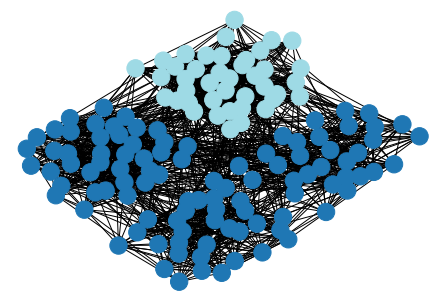

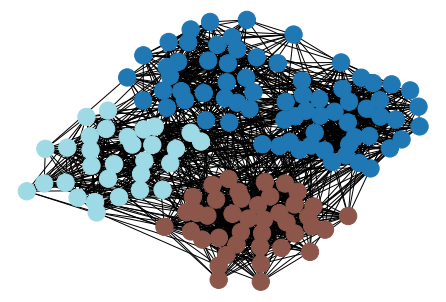

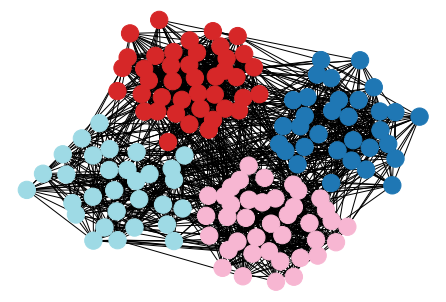

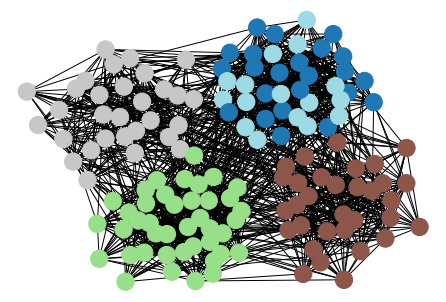

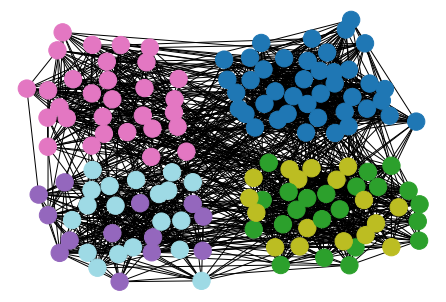

In [6]:
k=4
for i in range(2,k+3):
    X = LMSBMve[:,0:i]


    kmeans = KMeans(n_clusters=i, random_state=0).fit(X)
    plt.figure()
    nx.draw(SBM, node_color = kmeans.labels_, cmap = 'tab20')
    plt.show()


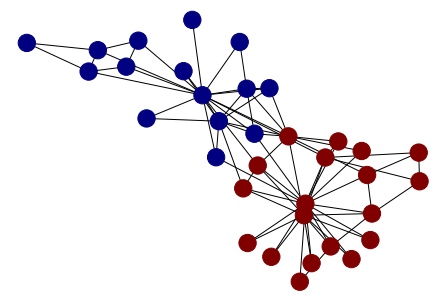

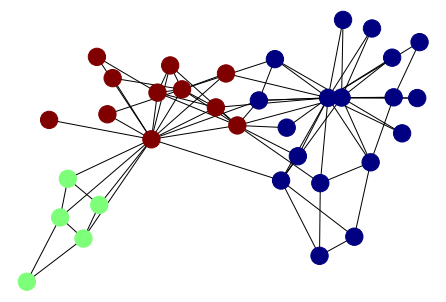

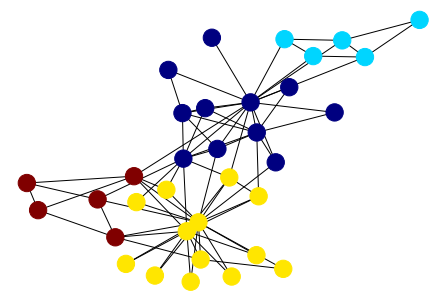

In [7]:
k=4
for i in range(2,k+1):
    X = LMKve[:,0:i]
    kmeans = KMeans(n_clusters=i).fit(X)
    plt.figure()
    nx.draw(K, node_color = kmeans.labels_, cmap = 'jet')
    plt.show()


The cells above plot the results of clustering each of the networks with different values of k. Which value of k is best for each network?

**Assignment:** Make a larger SBM with 8 instead of 4 clusters. What value of k returns the best result for this new network?

# Networkx Functions

Spectral clustering is not the only kind of clustering method that makes sense for networks. There are several other functions included in the networkx package that will find different types of clusters. These need to be imported separately in the cell below and you can see the complete list with examples here: https://networkx.org/documentation/stable/reference/algorithms/community.html

In [8]:
from networkx.algorithms import community

In [9]:
gmc = list(nx.algorithms.community.greedy_modularity_communities(K))
lpc = list(nx.algorithms.community.label_propagation_communities(K))
#lc = nx.algorithms.community.louvain_communities(K)

gmc_dict = dict()
for i in range(len(gmc)):
    for z in list(gmc[i]):
        gmc_dict[z] = i

lpc_dict = dict()
for i in range(len(lpc)):
    for z in list(lpc[i]):
        lpc_dict[z] = i

    

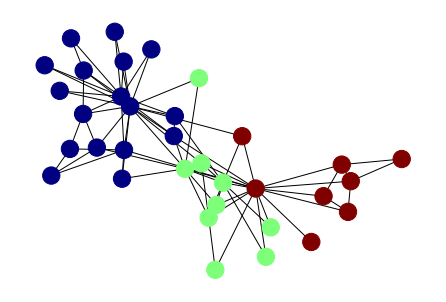

In [10]:
nx.draw(K, node_color = [gmc_dict[x] for x in K.nodes()], cmap = 'jet')


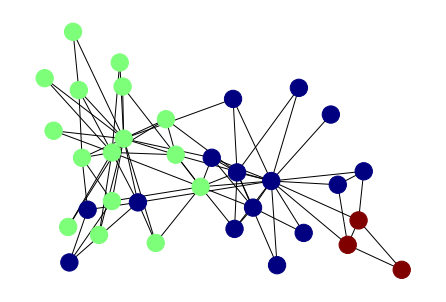

In [11]:
nx.draw(K, node_color = [lpc_dict[x] for x in K.nodes()], cmap = 'jet')


**Assignment:** Rerun the cell that finds the clusters several times. How long does it take to find a clustering that you are happy with for each method?